# The Kolmogorov-Smirnov distribution

In this example, we draw the Kolmogorov-Smirnov distribution for a sample size 10. We want to test the hypothesis that this sample has the `Uniform(0,1)` distribution. The K.S. distribution is first plot in the case where the parameters of the Uniform distribution are known. Then we plot the distribution when the parameters of the Uniform distribution are estimated from the sample.

*Reference* : Hovhannes Keutelian, "The Kolmogorov-Smirnov test when parameters are estimated from data", 30 April 1991, Fermilab

There is a bug in the paper; the equation:
```
D[i]=max(abs(S+step),D[i]) 
```
must be replaced with 
```
D[i]=max(abs(S-step),D[i]) 
```

In [1]:
import openturns as ot

In [2]:
x=[0.9374, 0.7629, 0.4771, 0.5111, 0.8701, 0.0684, 0.7375, 0.5615, 0.2835, 0.2508]
sample=ot.Sample([[xi] for xi in x])

In [3]:
samplesize = sample.getSize()
samplesize

10

Plot the empirical distribution function.

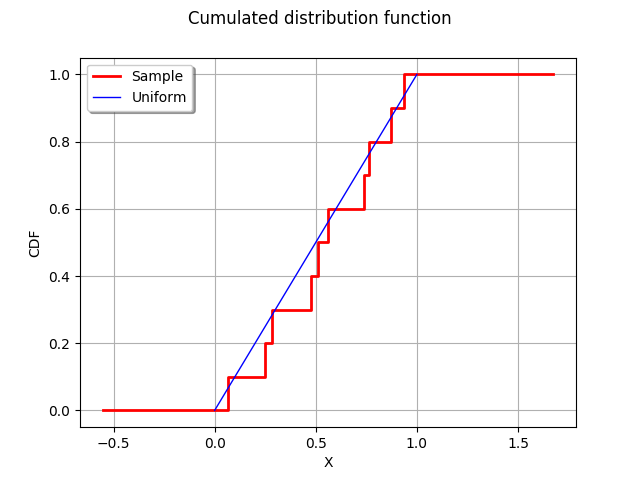

In [4]:
graph = ot.UserDefined(sample).drawCDF()
graph.setLegends(["Sample"])
curve = ot.Curve([0,1],[0,1])
curve.setLegend("Uniform")
graph.add(curve)
graph.setXTitle("X")
graph.setTitle("Cumulated distribution function")
graph

The computeKSStatisticsIndex function computes the Kolmogorov-Smirnov distance between the sample and the distribution. The following function is for teaching purposes only: use `FittingTest` for real applications.

In [5]:
def computeKSStatistics(sample,distribution):
    sample = sample.sort()
    n = sample.getSize()
    D = 0.
    index = -1
    D_previous = 0.
    for i in range(n):
        F = distribution.computeCDF(sample[i])
        Fminus = F - float(i)/n
        Fplus = float(i+1)/n - F
        D = max(Fminus,Fplus,D)
        if (D > D_previous):
            index = i
            D_previous = D
    return D

In [6]:
dist = ot.Uniform(0,1)
dist

class=Uniform name=Uniform dimension=1 a=0 b=1

In [7]:
computeKSStatistics(sample,dist)

0.17710000000000004

The following function generates a sample of K.S. distances when the tested distribution is the `Uniform(0,1)` distribution.

In [8]:
def generateKSSampleKnownParameters(nrepeat,samplesize):
    """
    nrepeat : Number of repetitions, size of the table
    samplesize : the size of each sample to generate from the Uniform distribution
    """
    dist = ot.Uniform(0,1)
    D = ot.Sample(nrepeat,1)
    for i in range(nrepeat):
        sample = dist.getSample(samplesize)
        D[i,0] = computeKSStatistics(sample,dist)
    return D

Generate a sample of KS distances. 

In [9]:
nrepeat = 10000 # Size of the KS distances sample
sampleD = generateKSSampleKnownParameters(nrepeat,samplesize)

Compute exact Kolmogorov PDF.

In [10]:
def pKolmogorovPy(x):
    y=ot.DistFunc_pKolmogorov(samplesize,x[0])
    return [y]

In [11]:
pKolmogorov = ot.PythonFunction(1,1,pKolmogorovPy)

In [12]:
def dKolmogorov(x,samplesize):
    """
    Compute Kolmogorov PDF for given x.
    x : an array, the points where the PDF must be evaluated
    samplesize : the size of the sample
    Reference
    Numerical Derivatives in Scilab, Michael Baudin, May 2009
    """
    n=x.getSize()
    y=ot.Sample(n,1)
    for i in range(n):
        y[i,0] = pKolmogorov.gradient(x[i])[0,0]
    return y

In [13]:
def linearSample(xmin,xmax,npoints):
    '''Returns a sample created from a regular grid 
    from xmin to xmax with npoints points.'''
    step = (xmax-xmin)/(npoints-1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

In [14]:
n = 1000 # Number of points in the plot
s = linearSample(0.001,0.999,n)
y = dKolmogorov(s,samplesize)

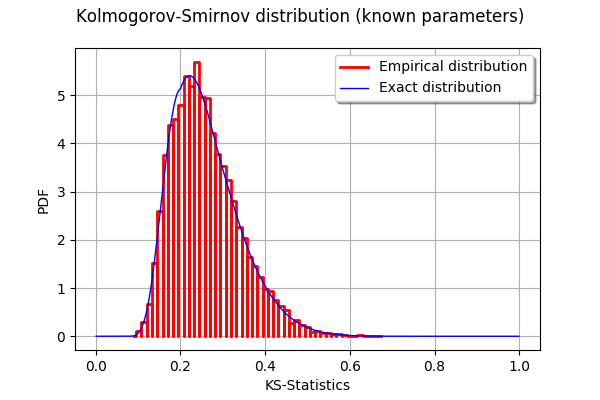

In [15]:
curve = ot.Curve(s,y)
curve.setLegend("Exact distribution")
graph = ot.HistogramFactory().build(sampleD).drawPDF()
graph.setLegends(["Empirical distribution"])
graph.add(curve)
graph.setTitle("Kolmogorov-Smirnov distribution (known parameters)")
graph.setXTitle("KS-Statistics")
graph

## Known parameters versus estimated parameters

The following function generates a sample of K.S. distances when the tested distribution is the `Uniform(a,b)` distribution, where the `a` and `b` parameters are estimated from the sample.

In [16]:
def generateKSSampleEstimatedParameters(nrepeat,samplesize):
    """
    nrepeat : Number of repetitions, size of the table
    samplesize : the size of each sample to generate from the Uniform distribution
    """
    distfactory = ot.UniformFactory()
    refdist = ot.Uniform(0,1)
    D = ot.Sample(nrepeat,1)
    for i in range(nrepeat):
        sample = refdist.getSample(samplesize)
        trialdist = distfactory.build(sample)
        D[i,0] = computeKSStatistics(sample,trialdist)
    return D

Generate a sample of KS distances. 

In [17]:
sampleDP = generateKSSampleEstimatedParameters(nrepeat,samplesize)

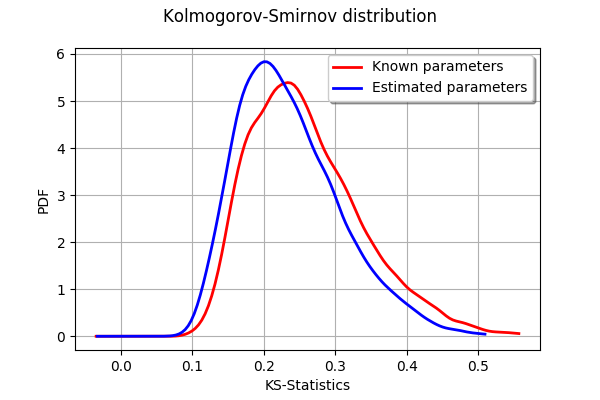

In [18]:
graph = ot.KernelSmoothing().build(sampleD).drawPDF()
graph.setLegends(["Known parameters"])
graphP = ot.KernelSmoothing().build(sampleDP).drawPDF()
graphP.setLegends(["Estimated parameters"])
graphP.setColors(["blue"])
graph.add(graphP)
graph.setTitle("Kolmogorov-Smirnov distribution")
graph.setXTitle("KS-Statistics")
graph

We see that the distribution of the KS distances when the parameters are estimated is shifted towards the left: smaller distances occur more often. This is a consequence of the fact that the estimated parameters tend to make the estimated distribution closer to the empirical sample. 